# Part I: Data Exploration 
We will begin this project by exploring the data in a bit more detail. Our aim here is to understand the data a bit better, as well as note down interesting insight that might be helpful when building the model. Note that the structure of the data is currently the same as it is on [Kaggle](https://www.kaggle.com/datasets/meetnagadia/collection-of-different-category-of-leaf-images).

Let's start by importing the necessary libraries:

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import random
import os

In [2]:
DATA_DIR = "datasets"
raw_data_dir = os.path.join(DATA_DIR, "raw_data")
plant_names = os.listdir(raw_data_dir)

print(plant_names)
print(len(plant_names))

['Alstonia Scholaris (P2)', 'Arjun (P1)', 'Chinar (P11)', 'Gauva (P3)', 'Jamun (P5)', 'Jatropha (P6)', 'Lemon (P10)', 'Mango (P0)', 'Pomegranate (P9)', 'Pongamia Pinnata (P7)']
10


We can see that we have 10 types plants in our data. Let's take a look at how the data is distributed:

In [3]:
data_counts = pd.DataFrame(columns=["Plant Name", "Healthy", "Diseased"])

for name in plant_names:
    plant_path = os.path.join(raw_data_dir, name)

    healthy_path = os.path.join(plant_path, "healthy")
    healthy_count = len(os.listdir(healthy_path))

    diseased_path = os.path.join(plant_path, "diseased")
    diseased_count = len(os.listdir(diseased_path))

    row = [name, healthy_count, diseased_count]
    data_counts.loc[len(data_counts)] = row

data_counts["Total"] = data_counts["Healthy"] + data_counts["Diseased"]
data_counts["Difference"] = data_counts["Healthy"] - data_counts["Diseased"]

last_row = ["Total", sum(data_counts["Healthy"]), 
            sum(data_counts["Diseased"]), sum(data_counts["Total"]),
            sum(data_counts["Difference"])]
data_counts.loc[len(data_counts)] = last_row

data_counts.set_index("Plant Name", inplace=True)

data_counts

,Healthy,Diseased,Total,Difference
Plant Name,,,,
Alstonia Scholaris (P2),179,254,433,-75
Arjun (P1),220,232,452,-12
Chinar (P11),103,120,223,-17
Gauva (P3),277,142,419,135
Jamun (P5),279,345,624,-66
Jatropha (P6),133,124,257,9
Lemon (P10),159,77,236,82
Mango (P0),170,265,435,-95
Pomegranate (P9),287,272,559,15


In total, we have 4,236 images in the dataset, with 2,129 images for healthy plants and 2,107 images for the diseased class. This might not be enough data to build an effective classification model, so we will augment the data by manipulating the existing images. 

The data is balanced enough for the classification task; the difference between healthy and diseased plants across the entire dataset is only 22 images in favor of the healthy class. When we look at some specific plants, however, we can see a much larger difference in the classes. For instance, the Gauva plant has 135 more images in its healthy class than in its diseased class. I am not going to rebalance the classes in any way, since, overall, the difference is insignificant, but it will be incredibly interesting to see how the plant-level imbalance affects the performance of our model. 

Let's move on now to seeing what a healthy and a diseased plant looks like across all of the species in the data. 

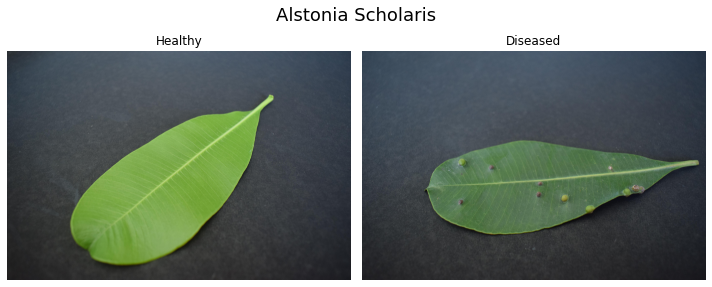

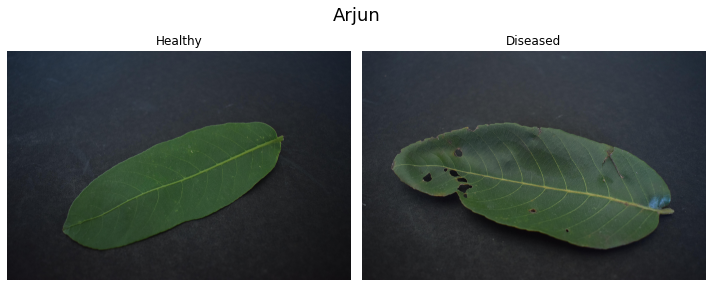

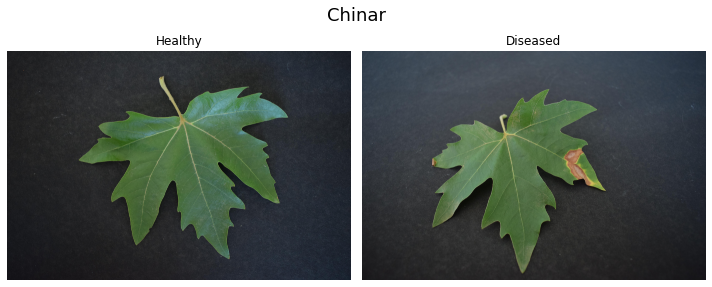

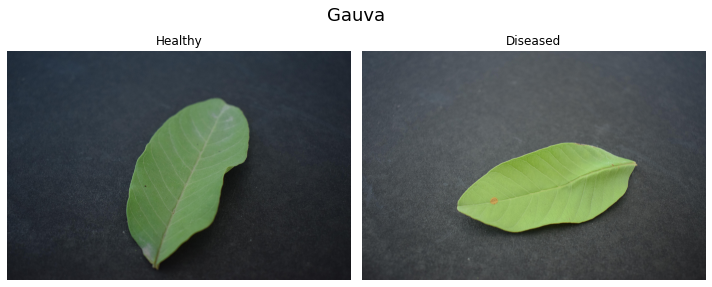

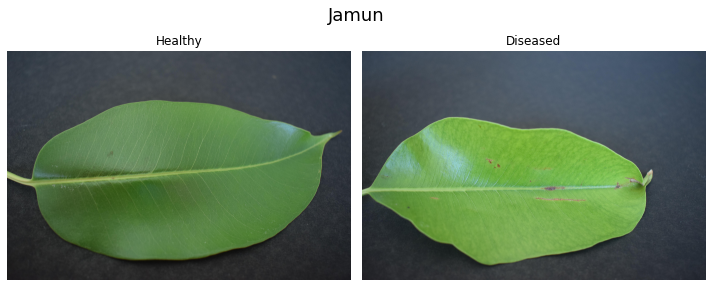

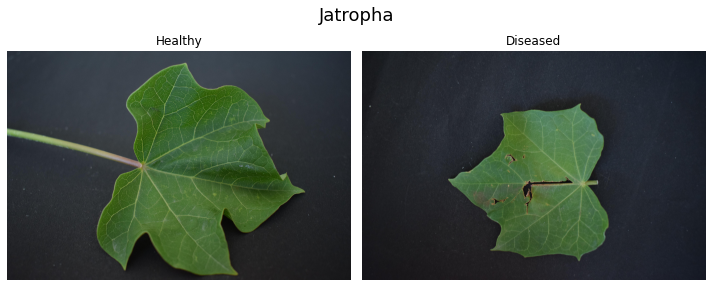

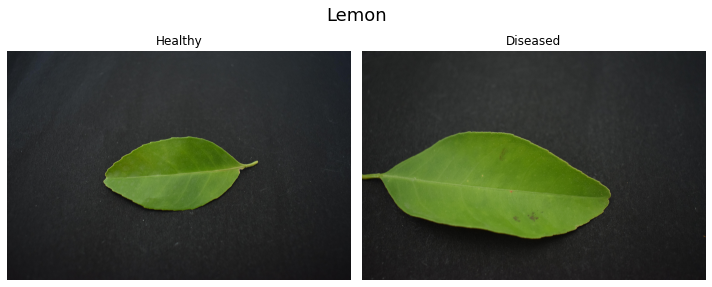

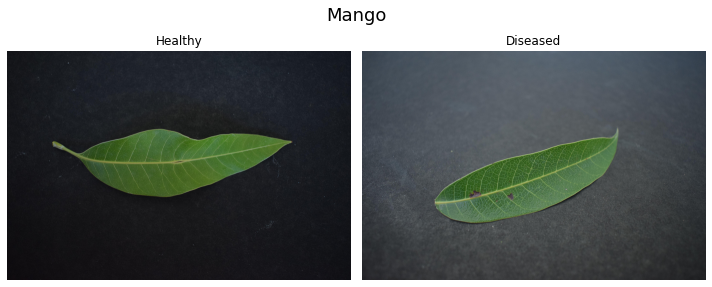

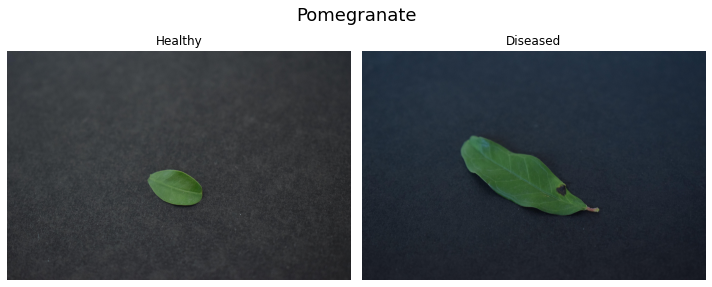

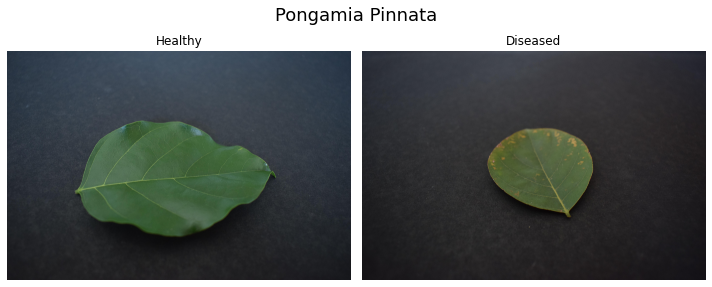

In [11]:
random.seed(2022)

for index, plant_name in enumerate(plant_names):
    plant_path = os.path.join(raw_data_dir, plant_name)

    # Create a separate figure for each plant
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    short_name = plant_name[:plant_name.find(" (")]
    fig.suptitle(short_name, y=0.9, fontsize=18)

    # Pick a randon healthy plant from each species
    healthy_path = os.path.join(plant_path, "healthy")
    random_healthy_plant = random.choice(os.listdir(healthy_path))
    random_healthy_plant_path = os.path.join(healthy_path, random_healthy_plant)
    # Display the healthy plant
    healthy_img = cv2.imread(random_healthy_plant_path)
    healthy_img = cv2.cvtColor(healthy_img, cv2.COLOR_BGR2RGB)
    axs[0].imshow(healthy_img)
    axs[0].set_title("Healthy")
    axs[0].axis("off")

    # Pick a random diseased plant from each species
    diseased_path = os.path.join(plant_path, "diseased")
    random_diseased_plant = random.choice(os.listdir(diseased_path))
    random_diseased_plant_path = os.path.join(diseased_path, random_diseased_plant)
    diseased_img = cv2.imread(random_diseased_plant_path)
    diseased_img = cv2.cvtColor(diseased_img, cv2.COLOR_BGR2RGB)
    # Display the diseased plant
    axs[1].imshow(diseased_img)
    axs[1].set_title("Diseased")
    axs[1].axis("off")
    fig.tight_layout()

    plt.show()

A few things to note down about these images:
1. The leaf takes up a relatively small proportion of the image
2. The images have a very similar background
3. There's not much difference in the shape of the leaf between a healthy example and a diseased example of a species
4. Color is the primary indicator of the leaf's health

These insights will be very useful to us when developing our model. For instance, we can expect a model that considers the color of the leaves to be more effective than a model that accepts a grayscale image, since color seems to play a major role in determining the leaf's health state. 

Let's now transform each image into a numpy array and save them to a single file that we will use later to train the model.

In [3]:
processed_data_dir = f"{DATA_DIR}/processed_data"
if not os.path.exists(processed_data_dir):
    os.mkdir(processed_data_dir)

In [4]:
oh_matrix = [[1, 0],
             [0, 1]]
status_dict = {"healthy": 0, "diseased": 1}
img_size = 64  # want to maintain high quality without blowing my RAM

def process_dir(filepath, status):
    processed = []
    oh_target = oh_matrix[status_dict[status]]

    for file in os.listdir(filepath):
        img_path = os.path.join(filepath, file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size, img_size))
        img_arr = np.array(img)

        processed.append((img_arr, oh_target))
        
    return processed

In [5]:
data = []
for plant_name in tqdm(plant_names):
    plant_path = os.path.join(raw_data_dir, plant_name)
    for status in os.listdir(plant_path):
        imgs_path = os.path.join(plant_path, status)
        processed = process_dir(imgs_path, status)
        data.extend(processed)

100%|██████████| 10/10 [19:11<00:00, 115.16s/it]


In [ ]:
np.save(f"{processed_data_dir}/X_y_data.npy", data)

### Future Plants
Now that we have processed our data and converted it to numerical features, we could start training our model right away. However, as you noticed, we only have just over 4,200 observations, which really isn't enough for a neural network. So, we will now split and augment the data to generate more training observations, which is likely to improve the accuracy of our model down the line. 

I'd love to hear your feedback! Feel free to open up an issue on GitHub or messaging me on [LinkedIn](https://www.linkedin.com/in/karim-zakir-172124171/)!